## Exploring HGMM

Questions:

Across all cells,

- What is the relation between the # of chimeras and the # and FS of real molecules (same gene)?
- What is the relation between the FS of chimeras and the # and FS of real molecules (same gene)?
- What is the relation between the # of chimeras and number of real molecules (other genes)?

In a given cell,

- What is the relation between the total # of real molecules and expression of inidividual genes (notion of droplet efficiency)?
- What is the relation between the # of chimeras (summed over all genes) and the # of real molecules (summed over all genes)?

In [2]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
from bisect import bisect_left, bisect_right
from commons import *
import tables
import scipy.sparse as sp

from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [6]:
dataset_name = 'hgmm_1k'
sc_fingerprint_path = '/home/jupyter/data/10x/hgmm_1k_v1_sc_fingerprint.pkl'

In [4]:
dataset_name = 'cho_hca_1'
sc_fingerprint_path = '/home/jupyter/data/10x/CHO_HCA_1_sc_fingerprint.pkl'

In [7]:
# load fingerprint and instantiate the data-store
sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path)
sc_fingerprint_base = sc_fingerprint_base.filter_genes(
    max_good_turing=1.,
    min_total_gene_expression=1.).sort_genes_by_expression()
sc_fingerprint_dtm = SingleCellFingerprintDTM(sc_fingerprint_base)

Calculating and caching "SingleCellFingerprintBase.good_turing_estimator_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Number of genes failed the maximum Good-Turing criterion: 29121
Number of genes failed the minimum expression criterion: 29121
Number of genes failed both criteria: 29121
Number of retained genes: 31615
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Calculating and caching "SingleCellFingerprintBase.sparse_count_matrix_csr"...


In [8]:
human_prefix = 'hg19'
mouse_prefix = 'mm10'
human_gene_indices = [i_gene
                      for i_gene, gene_idx in enumerate(sc_fingerprint_base.gene_idx_list)
                      if sc_fingerprint_base.gene_names_list[i_gene].find(human_prefix) != -1]
mouse_gene_indices = [i_gene
                      for i_gene, gene_idx in enumerate(sc_fingerprint_base.gene_idx_list)
                      if sc_fingerprint_base.gene_names_list[i_gene].find(mouse_prefix) != -1]

In [9]:
joint_count_matrix_csc = sp.csc_matrix(sc_fingerprint_base.sparse_count_matrix_csr)
human_count_matrix_csr = sp.csr_matrix(joint_count_matrix_csc[:, human_gene_indices])
mouse_count_matrix_csr = sp.csr_matrix(joint_count_matrix_csc[:, mouse_gene_indices])

In [10]:
human_total_expr = np.asarray(np.sum(human_count_matrix_csr, -1)).flatten()
mouse_total_expr = np.asarray(np.sum(mouse_count_matrix_csr, -1)).flatten()

In [11]:
human_cell_indices = np.where((human_total_expr > 1e3) & (mouse_total_expr < 1e3))[0]
mouse_cell_indices = np.where((mouse_total_expr > 1e3) & (human_total_expr < 1e3))[0]

Text(0.5, 0, 'Human UMI count')

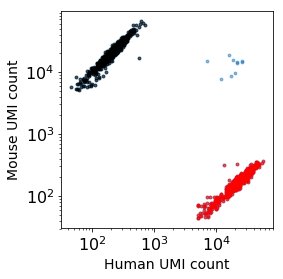

In [12]:
plt.scatter(human_total_expr, mouse_total_expr, s=8, alpha=0.5)
plt.scatter(human_total_expr[human_cell_indices], mouse_total_expr[human_cell_indices], color='red', s=8, alpha=0.5)
plt.scatter(human_total_expr[mouse_cell_indices], mouse_total_expr[mouse_cell_indices], color='black', s=8, alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect('equal')
plt.ylabel('Mouse UMI count', fontsize=14)
plt.xlabel('Human UMI count', fontsize=14)

In [41]:
dtm_e_hi_map_path = '/home/jupyter/data/10x/out/\
hgmm_1k_v1__all_genes__11__final_3_min_e_lo_frac_0.1/e_hi_map__full.npy'
e_hi_map = np.load(dtm_e_hi_map_path)

In [42]:
human_total_expr__dtm = np.sum(e_hi_map[:, human_gene_indices], -1)
mouse_total_expr__dtm = np.sum(e_hi_map[:, mouse_gene_indices], -1)

(0, 100000)

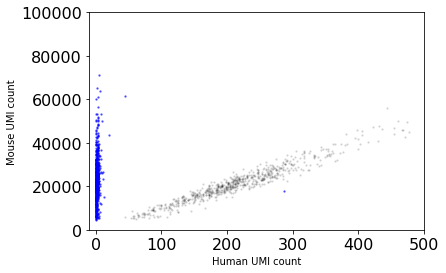

In [43]:
plt.scatter(
    human_total_expr[human_cell_indices],
    mouse_total_expr[human_cell_indices],
    color='red', s=2, alpha=0.1)

plt.scatter(
    human_total_expr__dtm[human_cell_indices],
    mouse_total_expr__dtm[human_cell_indices],
    color='red', s=2, alpha=0.5)

plt.scatter(
    human_total_expr[mouse_cell_indices],
    mouse_total_expr[mouse_cell_indices],
    color='black', s=2, alpha=0.1)

plt.scatter(
    human_total_expr__dtm[mouse_cell_indices],
    mouse_total_expr__dtm[mouse_cell_indices],
    color='blue', s=2, alpha=0.5)

plt.ylabel('Mouse UMI count')
plt.xlabel('Human UMI count')

plt.xlim((-10, 500))
plt.ylim((0, 100000))

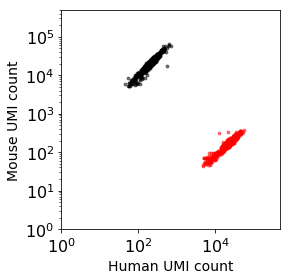

In [70]:
plt.scatter(
    1 + human_total_expr[human_cell_indices],
    1 + mouse_total_expr[human_cell_indices],
    color='red', s=8, alpha=0.5)

plt.scatter(
    1 + human_total_expr[mouse_cell_indices],
    1 + mouse_total_expr[mouse_cell_indices],
    color='black', s=8, alpha=0.5)

# plt.scatter(
#     1 + human_total_expr__dtm[human_cell_indices],
#     1 + mouse_total_expr__dtm[human_cell_indices],
#     color='red', s=8, alpha=0.5)

# plt.scatter(
#     1 + human_total_expr__dtm[mouse_cell_indices],
#     1 + mouse_total_expr__dtm[mouse_cell_indices],
#     color='black', s=8, alpha=0.5)



plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect('equal')
plt.ylabel('Mouse UMI count', fontsize=14)
plt.xlabel('Human UMI count', fontsize=14)

plt.xlim((1, 5e5))
plt.ylim((1, 5e5))
plt.tight_layout()
plt.savefig('/home/jupyter/CellBender/proto/chimera/notebooks/figures/hgmm_1k_raw.pdf')

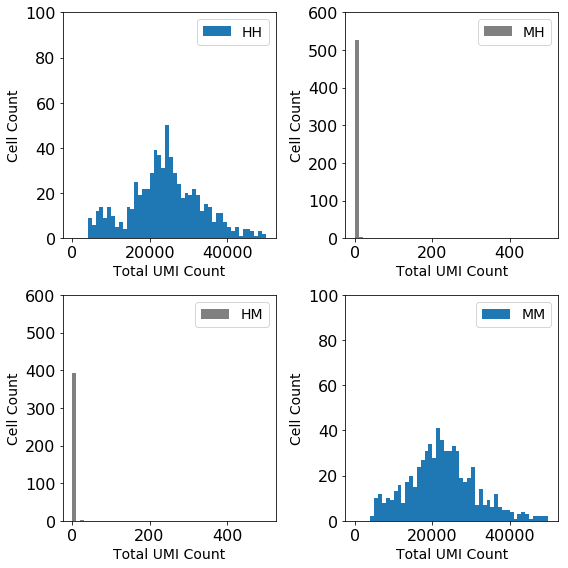

In [133]:
__human_total_expr = human_total_expr__dtm
__mouse_total_expr = mouse_total_expr__dtm

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].hist(__human_total_expr[human_cell_indices], range=(1, 5e4), bins=50, label='HH');
axs[0, 1].hist(__human_total_expr[mouse_cell_indices], range=(1, 5e2), bins=50, color='gray', label='MH');
axs[1, 1].hist(__mouse_total_expr[mouse_cell_indices], range=(1, 5e4), bins=50, label='MM');
axs[1, 0].hist(__mouse_total_expr[human_cell_indices], range=(1, 5e2), bins=50, color='gray', label='HM');
for ax in axs.flatten():
    ax.legend(fontsize=14)
    ax.set_xlabel('Total UMI Count', fontsize=14)
    ax.set_ylabel('Cell Count', fontsize=14)
    ax.set_ylim((0, 100))

axs[0, 1].set_ylim((0, 600))
axs[1, 0].set_ylim((0, 600))

plt.tight_layout()
plt.savefig('/home/jupyter/CellBender/proto/chimera/notebooks/figures/hgmm_after.pdf')

## Family Sizes

In [20]:
fs_list = []
for gene_list in [human_gene_indices, mouse_gene_indices]:
    for cell_list in [human_cell_indices, mouse_cell_indices]:
        fs = None
        for gene_index in gene_list:
            c_fs = sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index)[cell_list].sum(0)
            if fs is None:
                fs = c_fs
            else:
                fs += c_fs
        fs_list.append(fs)

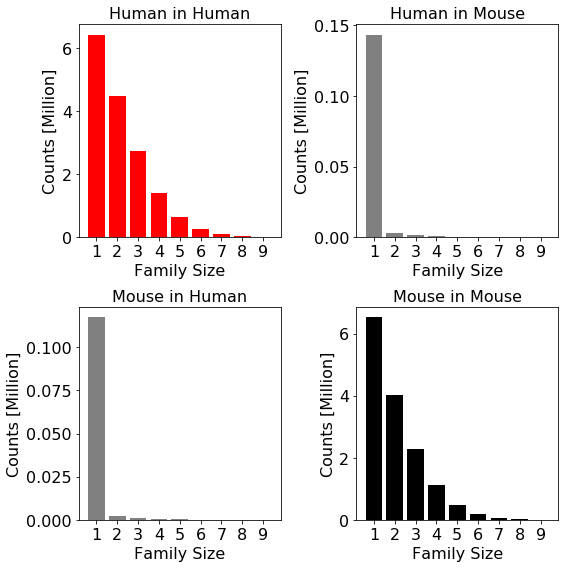

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].bar(x=np.arange(1, 10), height=fs_list[0][:9]/1_000_000, color='red');
axs[0, 0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9]);
axs[0, 0].set_xlabel('Family Size', fontsize=16)
axs[0, 0].set_ylabel('Counts [Million]', fontsize=16)
axs[0, 0].set_title('Human in Human', fontsize=16)

axs[0, 1].bar(x=np.arange(1, 10), height=fs_list[1][:9]/1_000_000, color='gray');
axs[0, 1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9]);
axs[0, 1].set_xlabel('Family Size', fontsize=16)
axs[0, 1].set_ylabel('Counts [Million]', fontsize=16)
axs[0, 1].set_title('Human in Mouse', fontsize=16)

axs[1, 0].bar(x=np.arange(1, 10), height=fs_list[2][:9]/1_000_000, color='gray');
axs[1, 0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9]);
axs[1, 0].set_xlabel('Family Size', fontsize=16)
axs[1, 0].set_ylabel('Counts [Million]', fontsize=16)
axs[1, 0].set_title('Mouse in Human', fontsize=16)

axs[1, 1].bar(x=np.arange(1, 10), height=fs_list[3][:9]/1_000_000, color='black');
axs[1, 1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9]);
axs[1, 1].set_xlabel('Family Size', fontsize=16)
axs[1, 1].set_ylabel('Counts [Million]', fontsize=16)
axs[1, 1].set_title('Mouse in Mouse', fontsize=16)

plt.tight_layout()
plt.savefig('/home/jupyter/CellBender/proto/chimera/notebooks/figures/hgmm_family_sizes.pdf')